In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import tensorflow as tf
from tensorflow.keras import models, layers

In [ ]:
# Adjust paths as needed
movies = pd.read_csv('/content/drive/MyDrive/project data/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/project data/tmdb_5000_credits.csv')



In [ ]:
# Merge datasets (if needed)
movies = movies.merge(credits, on='title')

# Keep relevant columns
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.dropna(inplace=True)

# Convert stringified lists to actual lists (for genres, keywords, cast, crew)
def convert(text):
    return [i['name'] for i in ast.literal_eval(text)]

movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)][:3])  # Top 3 actors
movies['crew'] = movies['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x) if i['job'] == 'Director'])

# Combine features into "tags"
movies['tags'] = movies['overview'] + ' ' + movies['genres'].apply(' '.join) + ' ' + \
                 movies['keywords'].apply(' '.join) + ' ' + movies['cast'].apply(' '.join) + ' ' + \
                 movies['crew'].apply(' '.join)

# Convert genres to binary labels (multi-label classification)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

In [ ]:
# Vectorize tags using CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words='english')
X = cv.fit_transform(movies['tags']).toarray()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, genres_encoded, test_size=0.2, random_state=42)

In [ ]:
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(genres_encoded.shape[1], activation='sigmoid')  # Multi-label classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.1813 - loss: 0.4929 - val_accuracy: 0.3823 - val_loss: 0.2659
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4526 - loss: 0.2364 - val_accuracy: 0.5449 - val_loss: 0.1617
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5383 - loss: 0.1452 - val_accuracy: 0.5813 - val_loss: 0.1122
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5580 - loss: 0.0991 - val_accuracy: 0.5722 - val_loss: 0.0906
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5536 - loss: 0.0740 - val_accuracy: 0.5709 - val_loss: 0.0839
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.5613 - loss: 0.0570 - val_accuracy: 0.5592 - val_loss: 0.0716
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5707 - loss: 0.0474 - val_accuracy: 0.5306 - val_loss: 0.0689
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5621 - loss: 0.0393 - val_accuracy: 0.5553 - v

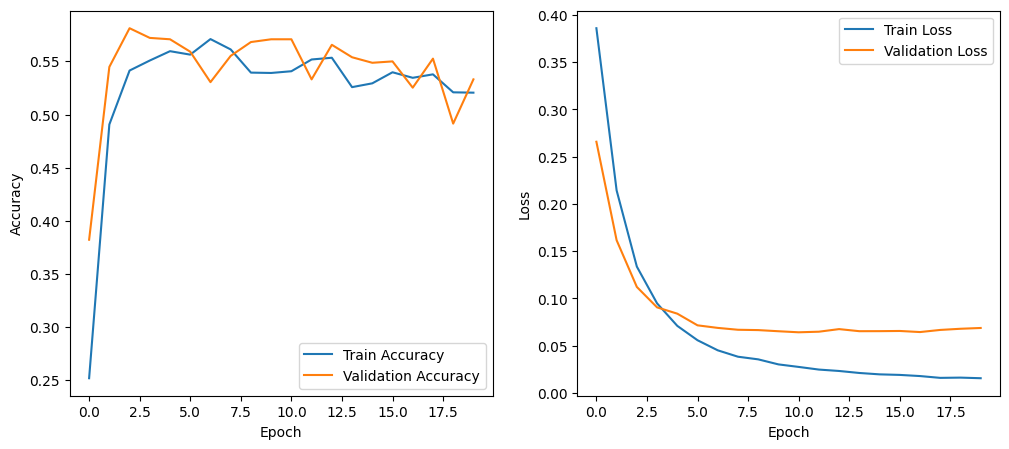

31/31 - 1s - 17ms/step - accuracy: 0.5094 - loss: 0.0688
Test Accuracy: 0.5093554854393005


In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


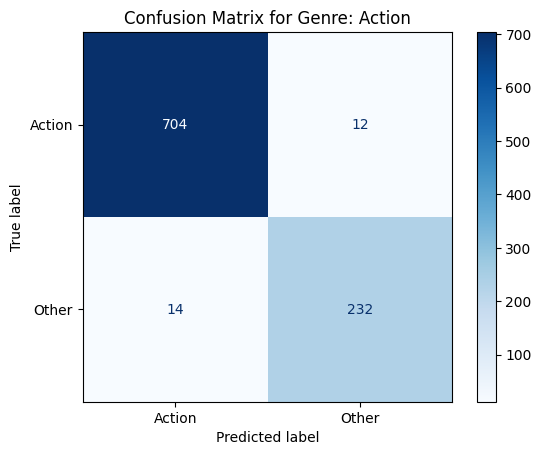

In [ ]:
# Predict genres for test data
y_pred = model.predict(X_test)
threshold = 0.5  # Adjust threshold for binary classification
y_pred_binary = (y_pred > threshold).astype(int)

# Plot confusion matrix for the first genre (e.g., "Action")
genre_idx = 0  # Replace with the index of the genre you want to analyze
cm = confusion_matrix(y_test[:, genre_idx], y_pred_binary[:, genre_idx])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[mlb.classes_[genre_idx], 'Other'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Genre: {mlb.classes_[genre_idx]}')
plt.show()

In [ ]:
def recommend_movies(model, movie_title, num_recommendations=5):
    # Find the movie's index
    idx = movies[movies['title'] == movie_title].index[0]

    # Get its vectorized features
    movie_features = X[idx].reshape(1, -1)

    # Predict genres
    predicted_genres = model.predict(movie_features)

    # Compute similarity with other movies using predicted genre probabilities
    similarity = cosine_similarity(predicted_genres, y_pred)[0]

    # Get top recommendations
    similar_indices = similarity.argsort()[-num_recommendations-1:-1][::-1]
    return movies.iloc[similar_indices]['title']

# Example usage
recommend_movies(model, 'Avatar')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


,title
46,X-Men: Days of Future Past
10,Superman Returns
813,Superman
3496,Morvern Callar
870,Superman II


In [ ]:
import pickle

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# X = your (n_movies × n_features) array from CountVectorizer, etc.
similarity = cosine_similarity(X)


In [ ]:
import os
import pickle

# 1) Create the folder if it doesn't already exist
if not os.path.exists('model'):
    os.makedirs('model')           # high-level directory creation :contentReference[oaicite:1]{index=1}

# 2) Serialize to binary files
with open('model/movie_list.pkl', 'wb') as f:
    pickle.dump(new, f)            # pickling your DataFrame :contentReference[oaicite:2]{index=2}

with open('model/similarity.pkl', 'wb') as f:
    pickle.dump(similarity, f)     # pickling your numpy array :contentReference[oaicite:3]{index=3}

print("✔️ Pickles saved under model/")


✔️ Pickles saved under model/


In [ ]:
from google.colab import files

files.download('model/movie_list.pkl')   # prompts browser download :contentReference[oaicite:5]{index=5}
files.download('model/similarity.pkl')   # prompts browser download :contentReference[oaicite:6]{index=6}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('model/similarity.pkl')   # prompts browser download :contentReference[oaicite:6]{index=6}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# X = your (n_movies × n_features) array from CountVectorizer
y_pred = model.predict(X)                        # shape: (n_movies, n_genres) :contentReference[oaicite:1]{index=1}
# Compute pairwise similarity over those predictions
similarity = cosine_similarity(y_pred)           # shape: (n_movies, n_movies) :contentReference[oaicite:2]{index=2}


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [ ]:
import os, pickle

# Ensure the folder exists
os.makedirs('model', exist_ok=True)             # binary safe with protocol ≥ 2 :contentReference[oaicite:3]{index=3}

# Save objects
pickle.dump(new,        open('model/movie_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(similarity, open('model/similarity.pkl','wb'), protocol=pickle.HIGHEST_PROTOCOL)
print("✔️ Pickles saved under model/")


✔️ Pickles saved under model/


In [ ]:
from google.colab import files

files.download('model/movie_list.pkl')           # Colab I/O helper :contentReference[oaicite:4]{index=4}
files.download('model/similarity.pkl')           # opens browser download dialog :contentReference[oaicite:5]{index=5}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
=== Classification Report ===
                 precision    recall  f1-score   support

         Action       0.95      0.94      0.95       246
      Adventure       0.88      0.96      0.92       167
      Animation       0.87      0.89      0.88        44
         Comedy       0.98      0.98      0.98       346
          Crime       0.89      0.84      0.87       138
    Documentary       0.94      0.83      0.88        18
          Drama       0.97      0.98      0.98       460
         Family       0.76      0.81      0.78        98
        Fantasy       0.96      0.71      0.82        98
        Foreign       0.00      0.00      0.00         5
        History       0.77      0.70      0.73        43
         Horror       0.94      0.99      0.97       100
          Music       0.79      0.54      0.64        35
        Mystery       1.00      0.81      0.90        69
        Romance       0.93      0.98      0.95       195
Science Fiction  

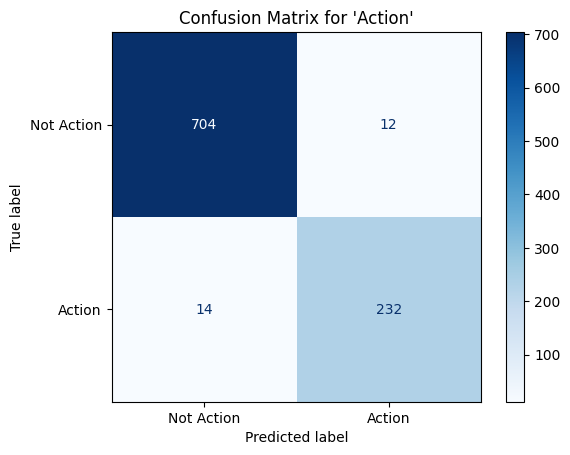


--- Adventure ---  TP=161, FP=21, TN=774, FN=6


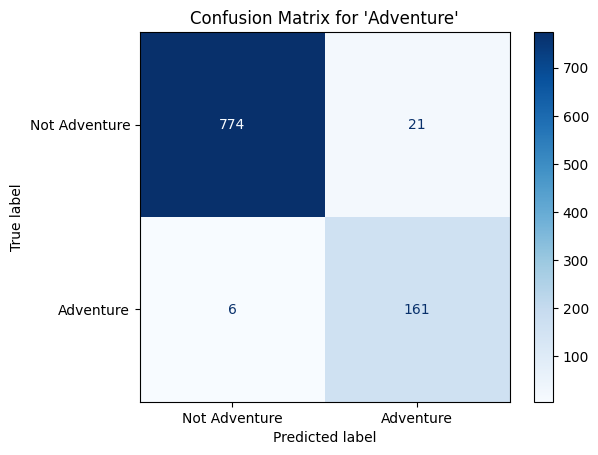


--- Animation ---  TP=39, FP=6, TN=912, FN=5


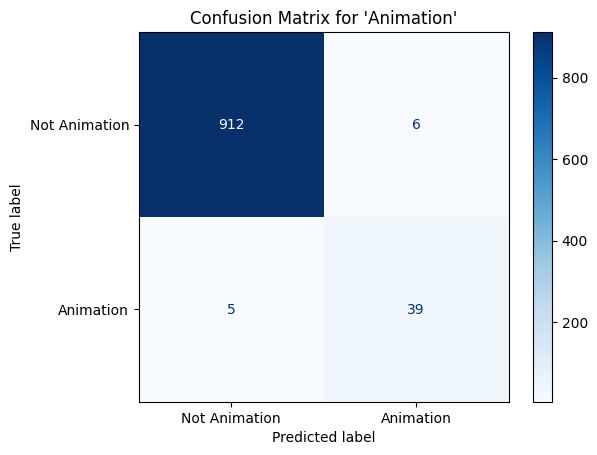


--- Comedy ---  TP=338, FP=8, TN=608, FN=8


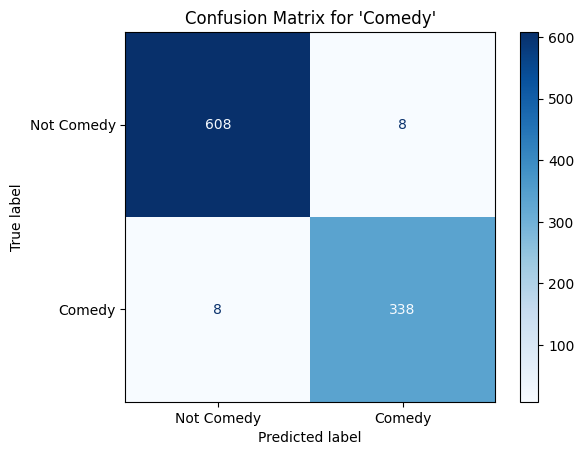


--- Crime ---  TP=116, FP=14, TN=810, FN=22


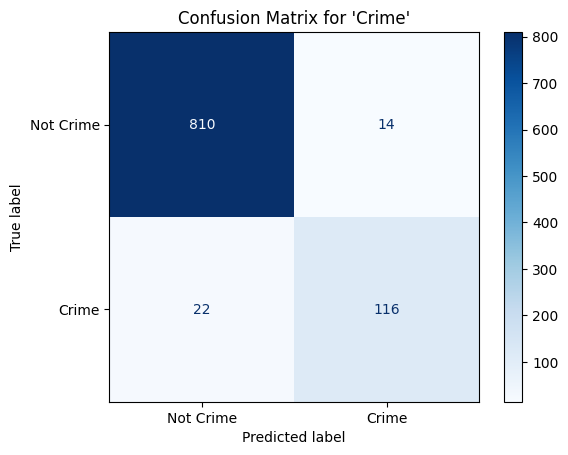


--- Documentary ---  TP=15, FP=1, TN=943, FN=3


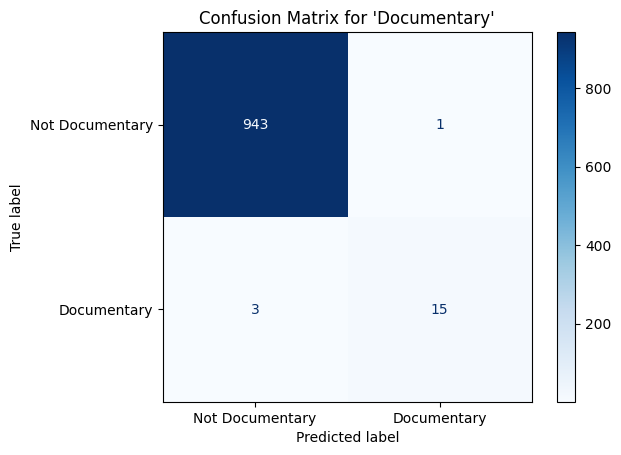


--- Drama ---  TP=453, FP=16, TN=486, FN=7


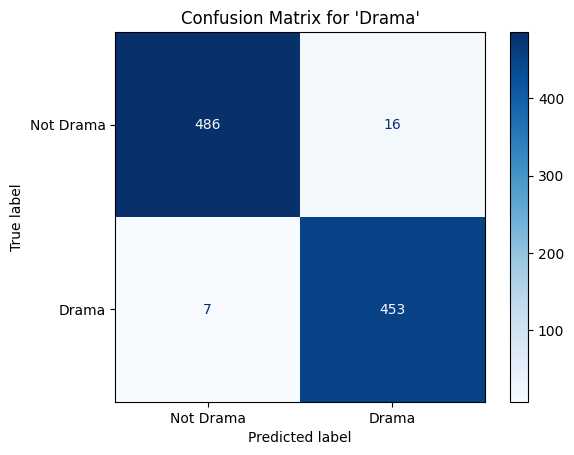


--- Family ---  TP=79, FP=25, TN=839, FN=19


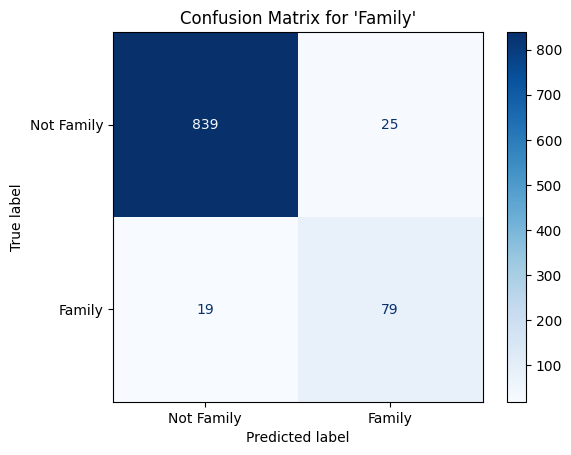


--- Fantasy ---  TP=70, FP=3, TN=861, FN=28


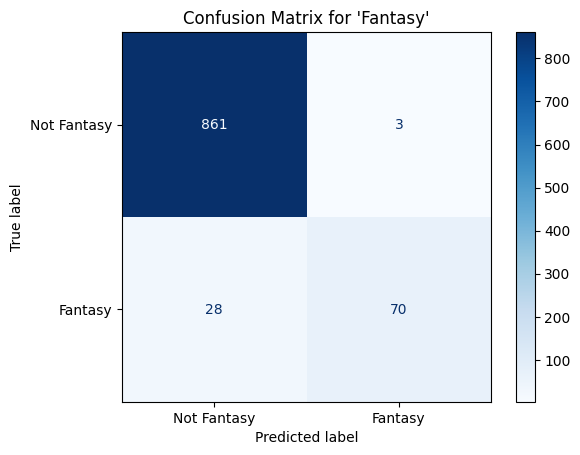


--- Foreign ---  TP=0, FP=0, TN=957, FN=5


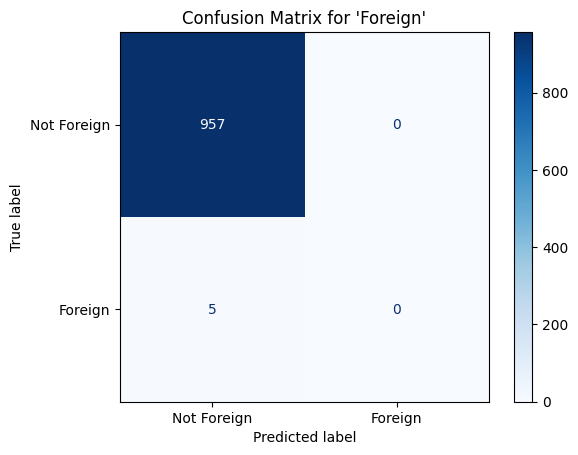


--- History ---  TP=30, FP=9, TN=910, FN=13


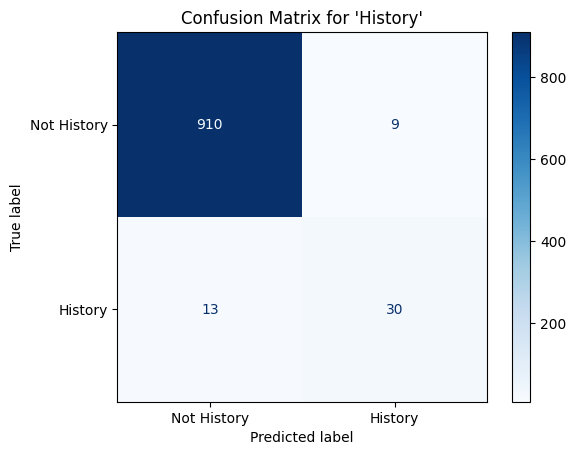


--- Horror ---  TP=99, FP=6, TN=856, FN=1


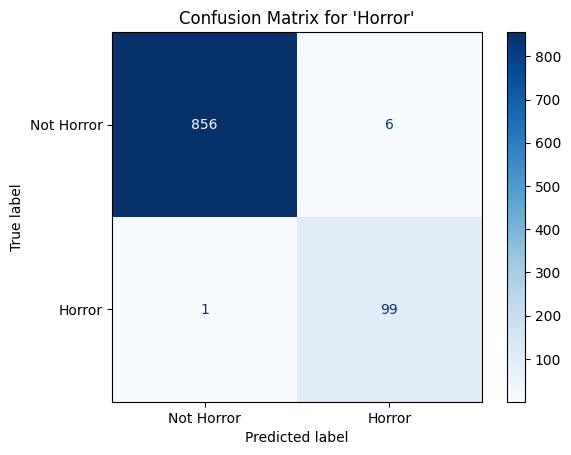


--- Music ---  TP=19, FP=5, TN=922, FN=16


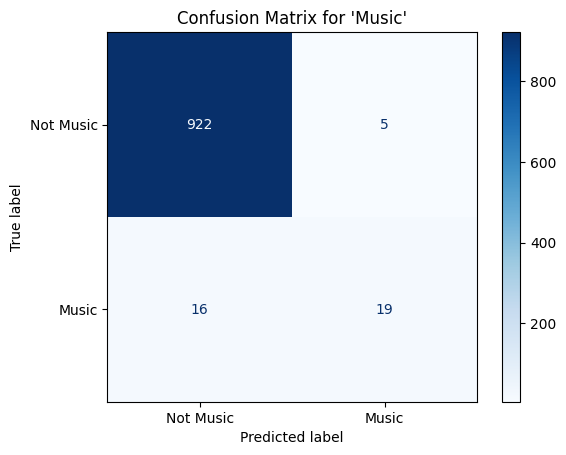


--- Mystery ---  TP=56, FP=0, TN=893, FN=13


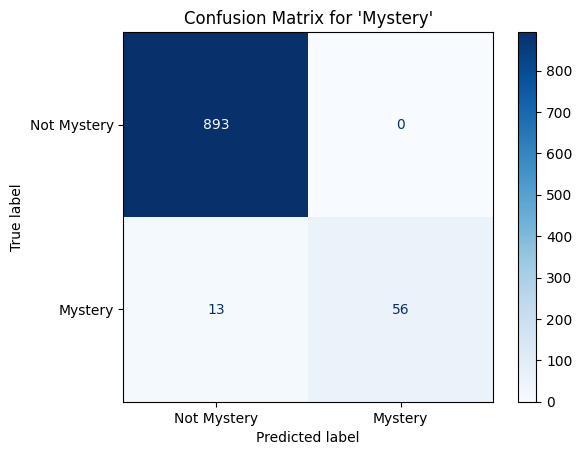


--- Romance ---  TP=191, FP=15, TN=752, FN=4


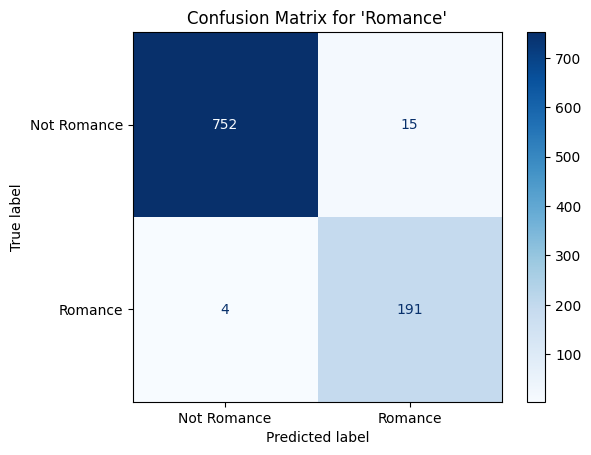


--- Science Fiction ---  TP=117, FP=1, TN=842, FN=2


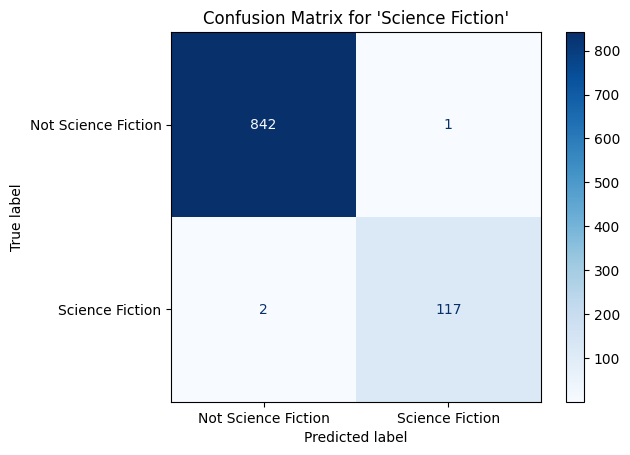


--- TV Movie ---  TP=0, FP=0, TN=959, FN=3


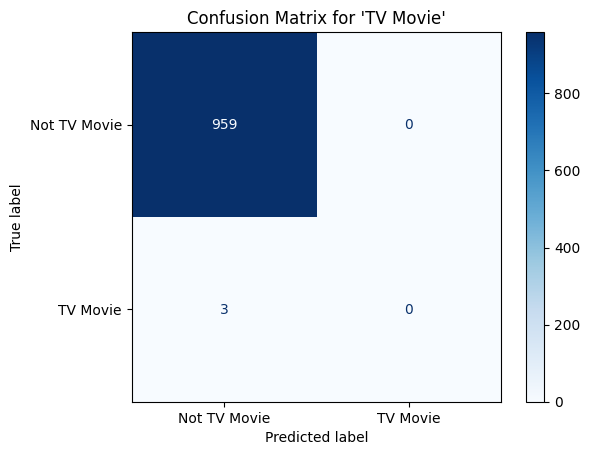


--- Thriller ---  TP=232, FP=11, TN=706, FN=13


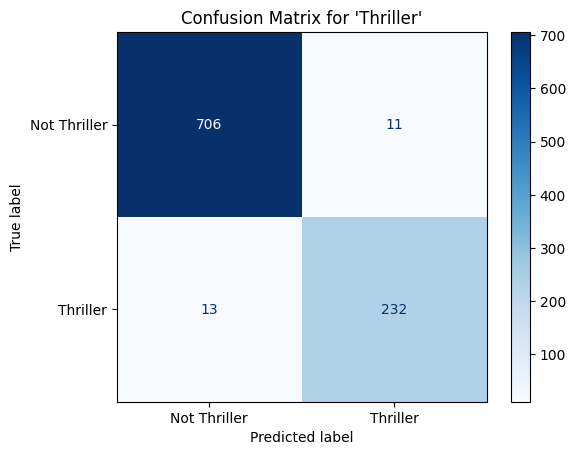


--- War ---  TP=23, FP=5, TN=927, FN=7


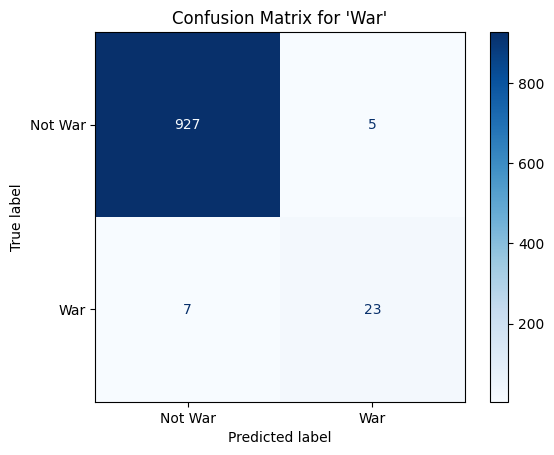


--- Western ---  TP=9, FP=0, TN=939, FN=14


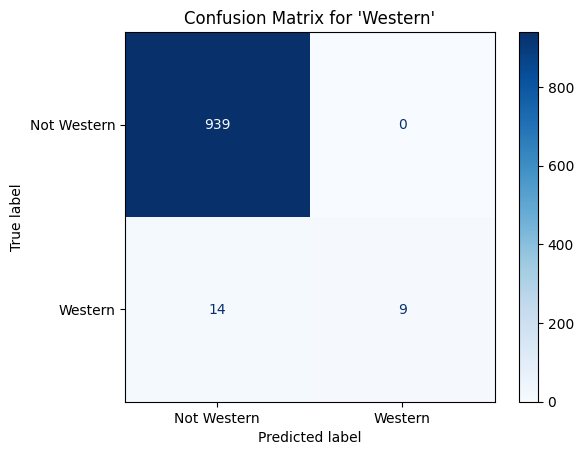

In [ ]:
from sklearn.metrics import (
    classification_report,
    hamming_loss,
    jaccard_score,
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Predict probabilities and binarize
y_pred_proba = model.predict(X_test)               # shape: (n_samples, n_genres)
threshold    = 0.5
y_pred       = (y_pred_proba >= threshold).astype(int)

# 2. Overall classification report
print("=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=mlb.classes_,
    zero_division=0
))

# 3. Multilabel metrics
print("Hamming Loss   :", hamming_loss(y_test, y_pred))
print("Jaccard (micro):", jaccard_score(y_test, y_pred, average='micro'))
print("Jaccard (macro):", jaccard_score(y_test, y_pred, average='macro'))

# 4. Confusion matrix per genre
mcm = multilabel_confusion_matrix(y_test, y_pred)

for idx, genre in enumerate(mlb.classes_):
    tn, fp, fn, tp = mcm[idx].ravel()
    print(f"\n--- {genre} ---  TP={tp}, FP={fp}, TN={tn}, FN={fn}")
    disp = ConfusionMatrixDisplay(
        confusion_matrix=mcm[idx],
        display_labels=[f"Not {genre}", genre]
    )
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for '{genre}'")
    plt.show()
